In [1]:
#%%writefile ../strace_miner/core/preprocessor.py

import os
import csv
import pandas as pd
from datetime import datetime

class Preprocessor():
    def __init__(self,strace_log_path,filtered_calls,name='filtered'):
         self.st_log = strace_log_path   
         self.csv_log = self.st_log.split('.st')[0]+'.csv'      
         self.filtered_calls = filtered_calls
         self.name = name
                  
         self.cols = ['call','time','duration']
         self.extra = []
         self.sys_time = 0.0
         self.io_time = 0.0
         self.total_time = 0.0
         self.dt_format = "%H:%M:%S.%f"
         self.stat_cols = ['call','duration','percent_total', 'percent_sys']


    def prepare_csv_log(self,fn_process_line):
        print("CSV log path: {}".format(self.csv_log))

        with open(self.st_log,'r') as in_f, open(self.csv_log,'w') as csv_f:
            csv_writer = csv.writer(csv_f)
            csv_writer.writerow(self.cols+self.extra)
            for line in in_f:
                ret = fn_process_line(line)
                csv_writer.writerow(ret)

    def get_df_from_csv(self,csv_file=None):
        if csv_file:
            self.csv_log = csv_file
        if not os.path.exists(self.csv_log):
            return None
        return pd.read_csv(self.csv_log,sep=',')
    
    def get_time_summary(self,df):
        stats = []
        ##get total time
        start = datetime.strptime(df['time'].iloc[0],self.dt_format)
        end = datetime.strptime(df['time'].iloc[-1],self.dt_format)
        self.total_time = (end-start).total_seconds()
        #print(self.total_time)
        stats.append(['Total',self.total_time,100.0,-1])

        ## get the time spent on all sys calls
        self.sys_time = df['duration'].sum()
        stats.append(['Sys time',self.sys_time,(self.sys_time/self.total_time)*100.0,100.0])

        return stats
    
    def process(self,df):
        summary = self.get_time_summary(df)

        if self.filtered_calls: 
            ## Filter the io_calls and find the time spent on io
            df = df[df['call'].isin(self.filtered_calls)]
            io_time = df['duration'].sum()
            summary.append(['{} time'.format(self.name),io_time,(io_time/self.total_time)*100.0, (io_time/self.sys_time)*100.0])

            remaining_time = self.sys_time - io_time
            summary.append(['Remaining sys time', remaining_time,
                        (remaining_time/self.total_time)*100.0,
                        (remaining_time/self.sys_time)*100.0])

            ## find the total duration of each io call
            grouped = df.groupby('call')
            sum_by_call = dict(grouped['duration'].sum())      
            for call,dur in sum_by_call.items():
                p_tot = (dur/self.total_time)*100.0
                p_sys = (dur/self.sys_time)*100.0      
                summary.append([call,dur,p_tot,p_sys])

        return pd.DataFrame(summary,columns=self.stat_cols),df
    



In [2]:
#%%writefile ../strace_miner/views/v1/io_preprocessor.py

#from ...core.preprocessor import Preprocessor
import pandas as pd

class IOPreprocessor(Preprocessor):
    def __init__(self, strace_log_path,filtered_calls):
        super().__init__(strace_log_path)
        self.filtered_calls = filtered_calls
    
    def process(self,df):
        summary,df = self.get_summary(df)
        return summary,df

    def get_summary(self,df):
        summary = self.get_time_summary(df)

        if self.filtered_calls: 
            ## Filter the io_calls and find the time spent on io
            df = df[df['call'].isin(self.filtered_calls)]
            io_time = df['duration'].sum()
            summary.append(['IO time',io_time,(io_time/self.total_time)*100.0, (io_time/self.sys_time)*100.0])

            remaining_time = self.sys_time - io_time
            summary.append(['Remaining sys time', remaining_time,
                        (remaining_time/self.total_time)*100.0,
                        (remaining_time/self.sys_time)*100.0])

            ## find the total duration of each io call
            grouped = df.groupby('call')
            sum_by_call = dict(grouped['duration'].sum())      
            for call,dur in sum_by_call.items():
                p_tot = (dur/self.total_time)*100.0
                p_sys = (dur/self.sys_time)*100.0      
                summary.append([call,dur,p_tot,p_sys])

        return pd.DataFrame(summary,columns=self.stat_cols),df
    


In [5]:
%%bash
strace -tt -T -r -o logs/mmarrays.st python src/mmarrays.py 100000

Data size = 819.200 MB
Chunk size = 0.800 MB


In [6]:
def process_line(line):
    ret = line.strip().split()
    time = ret[0]
    dur = ret[-1][1:-1]
    try:
        dur=float(dur)
    except ValueError:
        dur=0.0
    call = ret[3].split('(')[0]
    ret = [call,time,dur]
    #print(ret)
    return ret

io_calls = ['read','write','mmap','openat']
st = IOPreprocessor("logs/mmarrays.st",io_calls)
st.prepare_csv_log(process_line)

CSV log path: logs/mmarrays.csv


In [7]:
df_ = st.get_df_from_csv()

In [8]:
df_

,call,time,duration
0,execve,14:40:48.931673,0.000168
1,brk,14:40:48.932104,0.000030
2,readlink,14:40:48.932293,0.000047
3,access,14:40:48.932485,0.000033
4,openat,14:40:48.932640,0.000035
...,...,...,...
12780,munmap,14:40:51.655740,0.000105
12781,munmap,14:40:51.655971,0.000061
12782,munmap,14:40:51.656094,0.000060
12783,exit_group,14:40:51.656384,0.000000


In [9]:
summary_, df_ = st.process(df_)

In [10]:
summary_

,call,duration,percent_total,percent_sys
0,Total,2.728156,100.000000,-1.000000
1,Sys time,0.943920,34.599194,100.000000
2,IO time,0.552673,20.258116,58.550831
3,Remaining sys time,0.391247,14.341079,41.449169
4,mmap,0.030690,1.124936,3.251335
5,openat,0.091044,3.337199,9.645309
6,read,0.061644,2.259548,6.530638
7,write,0.369295,13.536433,39.123549


In [12]:
#%%writefile ../strace_miner/core/strace_analyzer.py

from abc import ABC, abstractmethod

class StraceAnalyzer(ABC):
    def __init__(self,st_log_paths):
        self.st_log_paths = st_log_paths
        self.st_logs = {}
        self.summaries = {}
        self.el = None

    @abstractmethod
    def process_line(self,line):
        pass

    @abstractmethod
    def preprocess(self,reuse=False):
        pass
    
    @abstractmethod
    def prepare_summaries_and_event_log(self):
        pass


In [16]:
#%%writefile ../strace_miner/views/v1/io_miner.py

import os
import pm4py 
import pandas as pd
#from ...core.strace_analyzer import StraceAnalyzer
#from .io_preprocessor import IOPreprocessor

class IOMiner(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.dfg = None
        self.dfg_im = None
        self.dfg_fm = None

    def process_line(self, line):
            ret = line.strip().split()
            time = ret[0]
            dur = ret[-1][1:-1]
            try:
                dur=float(dur)
            except ValueError:
                dur=0.0
            call = ret[3].split('(')[0]
            ret = [call,time,dur]
            #print(ret)
            return ret
    
    def preprocess(self,reuse=False):
         for st_path in self.st_log_paths: 
              st = IOPreprocessor(st_path,self.io_calls)
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log(self.process_line)
            
              self.st_logs[case_id] = st

    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df = pm4py.format_dataframe(df,case_id='case',activity_key='call',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)
         
         

Overwriting ../strace_miner/views/v1/io_miner.py


In [14]:
io_calls = ['read','write','mmap','openat']
sta = IOMiner(["logs/mmarrays.st",],io_calls)
sta.preprocess()
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

CSV log path: logs/mmarrays.csv


/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


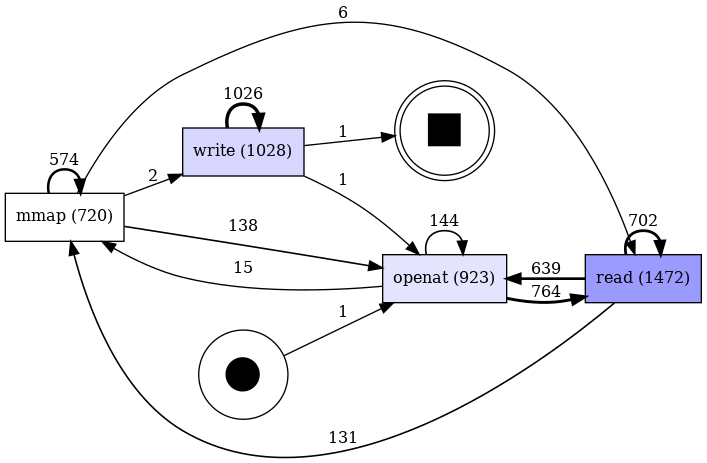

In [15]:
sta.view_dfg()

In [108]:
sta.summaries[list(sta.summaries.keys())[0]]

,call,duration,percent_total,percent_sys
0,Total,1.739921,100.000000,-1.000000
1,Sys time,0.692285,39.788301,100.000000
2,IO time,0.506407,29.105172,73.150075
3,Remaining sys time,0.185878,10.683129,26.849925
4,mmap,0.012447,0.715377,1.797959
5,openat,0.068707,3.948857,9.924670
6,read,0.017898,1.028667,2.585351
7,write,0.407355,23.412270,58.842095
